In [39]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import seaborn as sns # More snazzy plotting library
import itertools

In [2]:
pd.options.display.max_columns = 40

In [3]:
#open the file
file_path = "/home/user/projects/data_mining/predictive_data_mining/logistic_regression/working_dataset.csv"
dta = pd.read_csv(file_path)
dta.gross.median()

25517500.0

In [4]:
dta = dta.reindex_axis(sorted(dta.columns), axis=1)
dta.head(5)

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,aspect_ratio,budget,cast_total_facebook_likes,color,content_rating,country,director_facebook_likes,director_name,duration,facenumber_in_poster,genres,gross,imdb_score,language,movie_facebook_likes,movie_imdb_link,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,title_year
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,1.78,237000000.0,4834,Color,PG-13,USA,0.0,James Cameron,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,760505847.0,7.9,English,33000,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,Avatar,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,2009.0
1,40000.0,Johnny Depp,5000.0,Orlando Bloom,1000.0,Jack Davenport,2.35,300000000.0,48350,Color,PG-13,USA,563.0,Gore Verbinski,169.0,0.0,Action|Adventure|Fantasy,309404152.0,7.1,English,0,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,Pirates of the Caribbean: At World's End,302.0,1238.0,471220,goddess|marriage ceremony|marriage proposal|pi...,2007.0
2,11000.0,Christoph Waltz,393.0,Rory Kinnear,161.0,Stephanie Sigman,2.35,245000000.0,11700,Color,PG-13,UK,0.0,Sam Mendes,148.0,1.0,Action|Adventure|Thriller,200074175.0,6.8,English,85000,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,Spectre,602.0,994.0,275868,bomb|espionage|sequel|spy|terrorist,2015.0
3,27000.0,Tom Hardy,23000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,2.35,250000000.0,106759,Color,PG-13,USA,22000.0,Christopher Nolan,164.0,0.0,Action|Thriller,448130642.0,8.5,English,164000,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,The Dark Knight Rises,813.0,2701.0,1144337,deception|imprisonment|lawlessness|police offi...,2012.0
4,131.0,Doug Walker,12.0,Rob Walker,NaN,NaN,NaN,NaN,143,NaN,NaN,NaN,131.0,Doug Walker,NaN,0.0,Documentary,NaN,7.1,NaN,0,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,8,NaN,NaN


In [5]:
#clean up data non numeric rows
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in dta.iteritems():
    if type(colvalue[1]) == str:
        #if colname not in str_list:
            str_list.append(colname)
# Get to the numeric columns by inversion
num_list = dta.columns.difference(str_list)
#USe only the numeriv values
dta_clean = dta[num_list]
#remove the null values, that is fill NaN with there - FIXME: Rihards, naive implementation
dta_clean = dta_clean.fillna(value=0, axis=1)
dta_clean = dta_clean.reindex_axis(sorted(dta_clean.columns), axis=1)
dta_clean.head(10)

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
0,1000.0,936.0,855.0,1.78,237000000.0,4834,0.0,178.0,0.0,760505847.0,7.9,33000,723.0,3054.0,886204,2009.0
1,40000.0,5000.0,1000.0,2.35,300000000.0,48350,563.0,169.0,0.0,309404152.0,7.1,0,302.0,1238.0,471220,2007.0
2,11000.0,393.0,161.0,2.35,245000000.0,11700,0.0,148.0,1.0,200074175.0,6.8,85000,602.0,994.0,275868,2015.0
3,27000.0,23000.0,23000.0,2.35,250000000.0,106759,22000.0,164.0,0.0,448130642.0,8.5,164000,813.0,2701.0,1144337,2012.0
4,131.0,12.0,0.0,0.00,0.0,143,131.0,0.0,0.0,0.0,7.1,0,0.0,0.0,8,0.0
5,640.0,632.0,530.0,2.35,263700000.0,1873,475.0,132.0,1.0,73058679.0,6.6,24000,462.0,738.0,212204,2012.0
6,24000.0,11000.0,4000.0,2.35,258000000.0,46055,0.0,156.0,0.0,336530303.0,6.2,0,392.0,1902.0,383056,2007.0
7,799.0,553.0,284.0,1.85,260000000.0,2036,15.0,100.0,1.0,200807262.0,7.8,29000,324.0,387.0,294810,2010.0
8,26000.0,21000.0,19000.0,2.35,250000000.0,92000,0.0,141.0,4.0,458991599.0,7.5,118000,635.0,1117.0,462669,2015.0
9,25000.0,11000.0,10000.0,2.35,250000000.0,58753,282.0,153.0,3.0,301956980.0,7.5,10000,375.0,973.0,321795,2009.0


In [6]:
#clean up data from zero rows 
for colname, colvalue in dta_clean.iteritems():
    if colname != 'facenumber_in_poster':
        dta_clean = dta_clean[dta_clean[colname] != 0]
dta_clean.head(10)

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
3,27000.0,23000.0,23000.0,2.35,250000000.0,106759,22000.0,164.0,0.0,448130642.0,8.5,164000,813.0,2701.0,1144337,2012.0
5,640.0,632.0,530.0,2.35,263700000.0,1873,475.0,132.0,1.0,73058679.0,6.6,24000,462.0,738.0,212204,2012.0
7,799.0,553.0,284.0,1.85,260000000.0,2036,15.0,100.0,1.0,200807262.0,7.8,29000,324.0,387.0,294810,2010.0
9,25000.0,11000.0,10000.0,2.35,250000000.0,58753,282.0,153.0,3.0,301956980.0,7.5,10000,375.0,973.0,321795,2009.0
13,40000.0,5000.0,1000.0,2.35,225000000.0,48486,563.0,151.0,2.0,423032628.0,7.3,5000,313.0,1832.0,522040,2006.0
14,40000.0,2000.0,1000.0,2.35,215000000.0,45757,563.0,150.0,1.0,89289910.0,6.5,48000,450.0,711.0,181792,2013.0
18,40000.0,11000.0,1000.0,2.35,250000000.0,54083,252.0,136.0,4.0,241063875.0,6.7,58000,448.0,484.0,370704,2011.0
19,10000.0,816.0,718.0,1.85,225000000.0,12572,188.0,106.0,1.0,179020854.0,6.8,40000,451.0,341.0,268154,2012.0
21,15000.0,10000.0,963.0,2.35,230000000.0,28489,464.0,153.0,0.0,262030663.0,7.0,56000,599.0,1225.0,451803,2012.0
27,21000.0,19000.0,11000.0,2.35,250000000.0,64798,94.0,147.0,0.0,407197282.0,8.2,72000,516.0,1022.0,272670,2016.0


In [7]:
#add age column
dta_clean['age'] = 2017 - dta_clean['title_year']
#add new binary column which represents if gross is above the median gross or below
dta_clean['gross_median'] = (dta_clean.gross >= dta_clean.gross.median()).astype(int)
dta_clean.groupby('gross_median').head()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,age,gross_median
3,27000.0,23000.0,23000.0,2.35,250000000.0,106759,22000.0,164.0,0.0,448130642.0,8.5,164000,813.0,2701.0,1144337,2012.0,5.0,1
5,640.0,632.0,530.0,2.35,263700000.0,1873,475.0,132.0,1.0,73058679.0,6.6,24000,462.0,738.0,212204,2012.0,5.0,1
7,799.0,553.0,284.0,1.85,260000000.0,2036,15.0,100.0,1.0,200807262.0,7.8,29000,324.0,387.0,294810,2010.0,7.0,1
9,25000.0,11000.0,10000.0,2.35,250000000.0,58753,282.0,153.0,3.0,301956980.0,7.5,10000,375.0,973.0,321795,2009.0,8.0,1
13,40000.0,5000.0,1000.0,2.35,225000000.0,48486,563.0,151.0,2.0,423032628.0,7.3,5000,313.0,1832.0,522040,2006.0,11.0,1
281,752.0,631.0,591.0,1.85,90000000.0,3133,23.0,104.0,0.0,6712451.0,4.4,53,62.0,89.0,4102,2001.0,16.0,0
319,490.0,294.0,227.0,1.85,84000000.0,1195,6.0,94.0,0.0,17010646.0,2.2,881,78.0,239.0,40751,2005.0,12.0,0
320,26000.0,911.0,571.0,1.85,100000000.0,28328,2000.0,122.0,0.0,24985612.0,7.0,27000,289.0,161.0,71782,2015.0,2.0,0
321,3000.0,695.0,683.0,1.85,100000000.0,6161,31.0,95.0,1.0,4411102.0,3.8,416,66.0,164.0,20295,2002.0,15.0,0
324,623.0,508.0,393.0,1.85,10000000.0,1722,342.0,110.0,0.0,10200000.0,7.3,578,97.0,263.0,18697,1997.0,20.0,0


In [8]:
dta_clean.groupby('gross_median').mean()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,age
gross_median,,,,,,,,,,,,,,,,,
0,5224.698297,1220.974453,513.064477,2.066715,4.208863e+07,7631.384428,473.900243,105.708029,1.423358,8.034501e+06,6.202068,6666.590024,113.715328,159.991484,40165.950122,2002.418491,14.581509
1,10137.615572,3150.734793,1269.564477,2.161436,5.979957e+07,15914.428224,1727.557178,112.388078,1.368613,9.394518e+07,6.584428,25060.484185,242.993917,435.507299,178000.182482,2006.821168,10.178832


In [9]:
# show plots in the notebook
%matplotlib inline

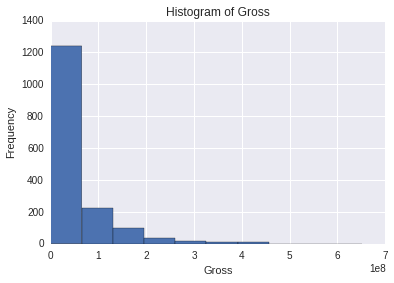

In [10]:
# histogram of gross
dta_clean.gross.hist()
plt.title('Histogram of Gross')
plt.xlabel('Gross')
plt.ylabel('Frequency')

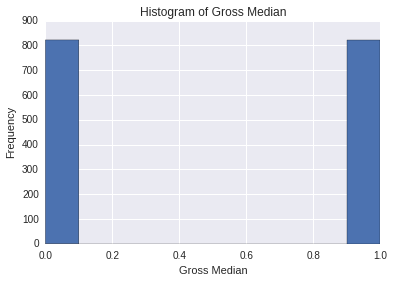

In [11]:
# histogram of gross median
dta_clean.gross_median.hist()
plt.title('Histogram of Gross Median')
plt.xlabel('Gross Median')
plt.ylabel('Frequency')

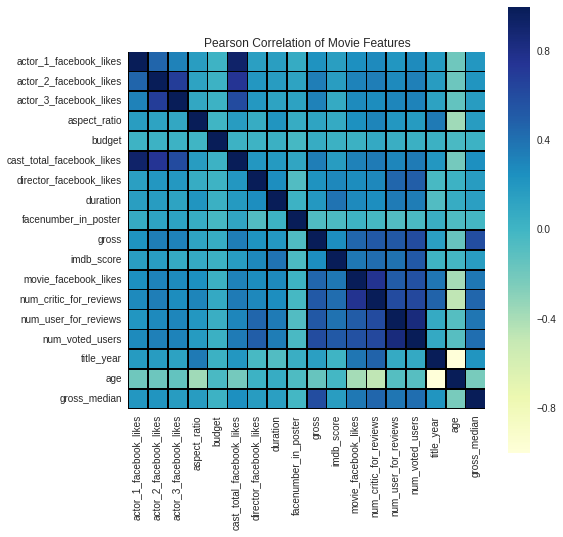

In [12]:
#plot pearsons coleration
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation of Movie Features')
# Draw the heatmap using seaborn
sns.heatmap(dta_clean.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black')

In [13]:
# create dataframes suitable for regression, with seperating predictors and outcomes. the predictors can be wrapped with a matching function in order to improve coleration linearity
y, X = dmatrices('gross_median ~  budget + cast_total_facebook_likes + \
                 director_facebook_likes + duration + facenumber_in_poster + imdb_score + \
                 movie_facebook_likes + num_critic_for_reviews + num_user_for_reviews + num_voted_users + title_year',
                 dta_clean, return_type="dataframe")
X.head()

,Intercept,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
3,1.0,250000000.0,106759.0,22000.0,164.0,0.0,8.5,164000.0,813.0,2701.0,1144337.0,2012.0
5,1.0,263700000.0,1873.0,475.0,132.0,1.0,6.6,24000.0,462.0,738.0,212204.0,2012.0
7,1.0,260000000.0,2036.0,15.0,100.0,1.0,7.8,29000.0,324.0,387.0,294810.0,2010.0
9,1.0,250000000.0,58753.0,282.0,153.0,3.0,7.5,10000.0,375.0,973.0,321795.0,2009.0
13,1.0,225000000.0,48486.0,563.0,151.0,2.0,7.3,5000.0,313.0,1832.0,522040.0,2006.0


In [14]:
# flatten y into a 1-D array
y = np.ravel(y)

In [15]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.73418491484184911

In [16]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[-2.9720754989e-07]
1,budget,[5.39611381572e-12]
2,cast_total_facebook_likes,[1.14560965642e-05]
3,director_facebook_likes,[6.88104794992e-06]
4,duration,[-3.17452276986e-05]
5,facenumber_in_poster,[-4.71928314738e-07]
6,imdb_score,[-2.05448365889e-06]
7,movie_facebook_likes,[2.41000465504e-05]
8,num_critic_for_reviews,[-8.42828501093e-06]
9,num_user_for_reviews,[-7.27001362098e-06]


In [17]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
print X_train
print y_train

      Intercept       budget  cast_total_facebook_likes  \
235         1.0  120000000.0                    22004.0   
3344        1.0   12000000.0                     8532.0   
110         1.0  155000000.0                      764.0   
2959        1.0   12000000.0                     3798.0   
4583        1.0    1000000.0                     2489.0   
590         1.0  100000000.0                    16235.0   
1282        1.0   40000000.0                     3126.0   
799         1.0   65000000.0                     1262.0   
3938        1.0    4000000.0                    13607.0   
5029        1.0    1000000.0                      115.0   
5004        1.0      30000.0                       72.0   
106         1.0  170000000.0                    80806.0   
3353        1.0    8500000.0                     4168.0   
983         1.0   50000000.0                    30183.0   
2712        1.0   15000000.0                      173.0   
1063        1.0   47000000.0                     8349.0 

In [18]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[ 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.  0.
  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.
  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.
  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.
  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.
  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.
  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.
  1.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.
  0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0

In [19]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[  7.58893566e-01   2.41106434e-01]
 [  7.67256313e-01   2.32743687e-01]
 [  6.95623792e-01   3.04376208e-01]
 [  7.73757074e-01   2.26242926e-01]
 [  2.45157350e-01   7.54842650e-01]
 [  7.35822161e-01   2.64177839e-01]
 [  3.59499475e-01   6.40500525e-01]
 [  7.71374381e-01   2.28625619e-01]
 [  7.54502807e-01   2.45497193e-01]
 [  7.63063126e-01   2.36936874e-01]
 [  1.43225220e-01   8.56774780e-01]
 [  3.28046646e-02   9.67195335e-01]
 [  9.50800756e-02   9.04919924e-01]
 [  7.01840419e-01   2.98159581e-01]
 [  3.60549567e-01   6.39450433e-01]
 [  5.86102374e-01   4.13897626e-01]
 [  3.26648638e-01   6.73351362e-01]
 [  7.45962913e-01   2.54037087e-01]
 [  7.37088697e-01   2.62911303e-01]
 [  1.20566695e-01   8.79433305e-01]
 [  2.84027565e-01   7.15972435e-01]
 [  7.25124180e-01   2.74875820e-01]
 [  7.65064416e-01   2.34935584e-01]
 [  3.75031939e-01   6.24968061e-01]
 [  2.53535095e-03   9.97464649e-01]
 [  7.20194854e-01   2.79805146e-01]
 [  7.69326868e-01   2.30673132e-01]
 

In [20]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.736842105263
0.843946953782


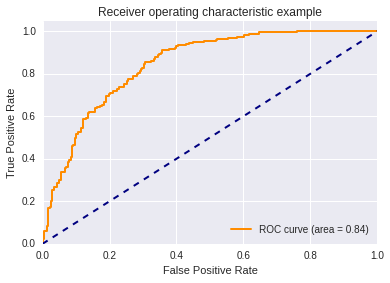

In [21]:
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [22]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.86144578  0.81325301  0.76219512  0.62804878  0.68292683  0.68902439
  0.74390244  0.67682927  0.68292683  0.74390244]
0.728445489274


In [23]:
X.head()

,Intercept,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
3,1.0,250000000.0,106759.0,22000.0,164.0,0.0,8.5,164000.0,813.0,2701.0,1144337.0,2012.0
5,1.0,263700000.0,1873.0,475.0,132.0,1.0,6.6,24000.0,462.0,738.0,212204.0,2012.0
7,1.0,260000000.0,2036.0,15.0,100.0,1.0,7.8,29000.0,324.0,387.0,294810.0,2010.0
9,1.0,250000000.0,58753.0,282.0,153.0,3.0,7.5,10000.0,375.0,973.0,321795.0,2009.0
13,1.0,225000000.0,48486.0,563.0,151.0,2.0,7.3,5000.0,313.0,1832.0,522040.0,2006.0


In [24]:
# retry one class with normalised data

#scale columns 
#min_max_scaler = preprocessing.MinMaxScaler()
#for colname, colvalue in X.iteritems():
 #       X[colname] = min_max_scaler.fit_transform(X[colname])
for colname, colvalue in X.iteritems():
        nomalizer_scaler = preprocessing.Normalizer().fit(X[colname])
        X[colname] = nomalizer_scaler.transform(X[colname])[0] 



#separate test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2_norm = LogisticRegression()
model2_norm.fit(X_train, y_train)

# predict class labels for the test set
predicted_norm = model2_norm.predict(X_test)
probs_norm = model2.predict_proba(X_test)

# generate evaluation metrics
#print metrics.accuracy_score(y_test, predicted_norm)
#print metrics.roc_auc_score(y_test, probs_norm[:, 1])


# evaluate the model using 10-fold cross-validation
scores = cross_val_score(model2_norm, X, y, scoring='accuracy', cv=10)
#print scores
#print scores.mean()
X.head()

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

,Intercept,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
3,0.024663,0.019323,0.130366,0.143480,0.036356,0.000000,0.032303,0.136952,0.088273,0.142418,0.141908,0.024754
5,0.024663,0.020382,0.002287,0.003098,0.029262,0.009987,0.025082,0.020042,0.050162,0.038913,0.026315,0.024754
7,0.024663,0.020096,0.002486,0.000098,0.022168,0.009987,0.029643,0.024217,0.035179,0.020406,0.036559,0.024729
9,0.024663,0.019323,0.071744,0.001839,0.033918,0.029960,0.028503,0.008351,0.040716,0.051304,0.039906,0.024717
13,0.024663,0.017391,0.059207,0.003672,0.033474,0.019973,0.027743,0.004175,0.033985,0.096597,0.064738,0.024680


In [25]:
#remove gross median column
#dta_clean = dta_clean.drop('gross_median', 1)

def label_gross (gross):
    if (gross < 1000000) : return 1
    elif ((gross >= 1000000) & (gross < 10000000)) : return 2
    elif ((gross >= 10000000) & (gross < 50000000)) : return 3
    elif ((gross >= 50000000) & (gross < 200000000)) : return 4
    elif (gross >= 200000000) : return 5


dta_clean['gross_class'] = dta_clean.gross.apply (lambda gross: label_gross (gross))

#add new classes for median ranges - below 1 million, 1 to 10 million, 10 to 50 million, 50 to 200 million, over 200 million
#dta_clean['gross_class_b1'] = (dta_clean.gross < 1000000).astype(int)
#dta_clean['gross_class_1to10'] = ((dta_clean.gross >= 1000000) & (dta_clean.gross < 10000000)).astype(int)
#dta_clean['gross_class_10to50'] = ((dta_clean.gross >= 10000000) & (dta_clean.gross < 50000000)).astype(int)
#dta_clean['gross_class_50to200'] = ((dta_clean.gross >= 50000000) & (dta_clean.gross < 200000000)).astype(int)
#dta_clean['gross_class_ov200'] = (dta_clean.gross >= 200000000).astype(int)
dta_clean.groupby('gross_class').mean()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,age,gross_median
gross_class,,,,,,,,,,,,,,,,,,
1,4872.647343,813.352657,337.067633,2.054010,2.313721e+07,6536.922705,343.594203,103.449275,1.400966,2.784258e+05,6.296618,3950.821256,71.574879,99.140097,20494.135266,2003.584541,13.415459,0.000000
2,4856.123333,1091.363333,436.573333,2.039767,6.929697e+07,6985.750000,452.563333,107.393333,1.470000,4.558929e+06,6.352000,6102.696667,112.253333,153.643333,39143.450000,2001.020000,15.980000,0.000000
3,6793.242671,1777.576547,705.146580,2.124772,3.173488e+07,10203.524430,819.403909,107.166124,1.452769,2.583284e+07,6.113355,12450.390879,165.648208,246.273616,73724.254072,2004.661238,12.338762,0.486971
4,10753.901566,3234.125280,1240.425056,2.167360,6.454271e+07,16472.514541,1808.263982,113.375839,1.348993,9.798966e+07,6.680313,27488.782998,252.939597,452.572707,188984.413870,2006.986577,10.013423,1.000000
5,15582.921053,7377.447368,3646.657895,2.171184,1.294447e+08,29968.578947,3832.855263,120.578947,0.907895,2.992005e+08,7.392105,46039.473684,394.092105,912.802632,442164.671053,2007.394737,9.605263,1.000000


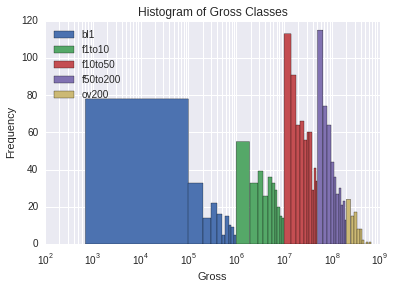

In [26]:
# histogram of gross with a logorithmic scale
dta_clean.gross[dta_clean.gross_class	 == 1].hist(label=['bl1'])
dta_clean.gross[dta_clean.gross_class	 == 2].hist(label=['f1to10'])
dta_clean.gross[dta_clean.gross_class	 == 3].hist(label=['f10to50'])
dta_clean.gross[dta_clean.gross_class	 == 4].hist(label=['f50to200'])
dta_clean.gross[dta_clean.gross_class	 == 5].hist(label=['ov200'])
plt.title('Histogram of Gross Classes')
plt.xlabel('Gross')
plt.ylabel('Frequency')
plt.gca().set_xscale("log")
plt.legend(loc="upper left")

In [27]:
#dta_clean.boxplot(by='gross_class')

In [28]:
# create dataframes suitable for regression, with seperating predictors and outcomes. the predictors can be wrapped with a matching function in order to improve coleration linearity
y, X = dmatrices('gross_class ~ actor_1_facebook_likes + actor_2_facebook_likes + \
                 actor_3_facebook_likes + aspect_ratio + budget + cast_total_facebook_likes + \
                 director_facebook_likes + duration + facenumber_in_poster + imdb_score + \
                 movie_facebook_likes + num_critic_for_reviews + num_user_for_reviews + num_voted_users + title_year',
                 dta_clean, return_type="dataframe")


In [29]:
# flatten y and x into a 1-D array
y = np.ravel(y)

In [30]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.47019464720194648

In [31]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[ 3.  3.  3.  3.  4.  3.  3.  3.  3.  3.  4.  4.  4.  3.  3.  3.  3.  3.
  3.  4.  3.  3.  3.  4.  4.  3.  3.  3.  3.  3.  4.  3.  3.  3.  2.  3.
  3.  3.  3.  3.  4.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  3.  3.
  4.  4.  4.  3.  4.  3.  3.  4.  4.  4.  3.  4.  4.  3.  3.  3.  3.  3.
  3.  3.  3.  4.  4.  3.  4.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  4.  3.  3.  3.  4.  4.  2.  3.  3.  4.  3.  3.  3.  3.  3.  3.  4.  3.
  4.  4.  3.  3.  4.  4.  3.  4.  3.  3.  2.  3.  4.  4.  3.  4.  4.  4.
  3.  3.  3.  3.  3.  4.  3.  3.  4.  3.  3.  3.  4.  4.  4.  3.  4.  2.
  3.  3.  4.  3.  2.  3.  4.  4.  4.  4.  4.  3.  4.  3.  3.  3.  4.  4.
  4.  3.  4.  3.  3.  3.  3.  3.  3.  3.  3.  4.  3.  4.  3.  3.  3.  4.
  3.  3.  4.  3.  4.  3.  4.  3.  3.  3.  3.  3.  3.  4.  3.  3.  3.  3.
  4.  3.  3.  3.  3.  3.  3.  3.  3.  4.  3.  3.  3.  3.  3.  4.  4.  4.
  3.  3.  3.  3.  3.  3.  3.  4.  4.  3.  3.  3.  4.  3.  3.  4.  3.  3.
  3.  3.  3.  4.  3.  4.  3.  3.  4.  3.  3.  3.  3

In [33]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[ 0.23033171  0.24868134  0.27592358  0.17036254  0.07470083]
 [ 0.24057501  0.25298236  0.26650488  0.16750094  0.07243681]
 [ 0.16366786  0.23821356  0.30235748  0.21155786  0.08420324]
 ..., 
 [ 0.25494976  0.25316717  0.26387623  0.1625882   0.06541864]
 [ 0.04142638  0.23236055  0.35796061  0.25912501  0.10912745]
 [ 0.29698163  0.22814778  0.2862108   0.17103385  0.01762594]]


In [34]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)


0.485829959514


In [35]:


## retry one class with normalised data
#normalize data 
#x_arr = X.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x_arr)
#X = pd.DataFrame(x_scaled)

#separate test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#try different solvers and normollised data
model3 = LogisticRegression(solver = "newton-cg")
model3.fit(X_train, y_train)
predicted3 = model3.predict(X_test)

model4 = LogisticRegression(solver = "lbfgs")
model4.fit(X_train, y_train)
predicted4 = model4.predict(X_test)

model5 = LogisticRegression(solver = "liblinear")
model5.fit(X_train, y_train)
predicted5 = model5.predict(X_test)

model6 = LogisticRegression(solver = "sag")
model6.fit(X_train, y_train)
predicted6 = model6.predict(X_test)

print "newton-cg solver accuracy"
print metrics.accuracy_score(y_test, predicted3)

print "lbfgs solver accuracy"
print metrics.accuracy_score(y_test, predicted4)

print "nliblinear solver accuracy"
print metrics.accuracy_score(y_test, predicted5)

print "sag solver accuracy"
print metrics.accuracy_score(y_test, predicted6)


/usr/local/lib/python2.7/dist-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


newton-cg solver accuracy
0.48987854251
lbfgs solver accuracy
0.443319838057
nliblinear solver accuracy
0.485829959514
sag solver accuracy
0.273279352227


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [37]:
scores = cross_val_score(model5, X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.48192771  0.51204819  0.46987952  0.45180723  0.46060606  0.44242424
  0.43902439  0.43209877  0.45679012  0.41358025]
0.456018647968


In [45]:
headers = list(dta_clean.columns.values)
headers.remove('gross_class')
headers.remove('gross_median')
headers.remove('age')
headers.remove('gross')
print headers
iterator = 0
for L in range(0, len(headers)+1):
    for subset in itertools.combinations(headers, L):
        iterator = iterator + 1
print iterator

['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'aspect_ratio', 'budget', 'cast_total_facebook_likes', 'director_facebook_likes', 'duration', 'facenumber_in_poster', 'imdb_score', 'movie_facebook_likes', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'title_year']
32768
